# Regression

In this notebook, we would try to tacckle the regression problem for the order arrivals in an LOB. However, it would not make sense if we do not consider predictions from classification and thus, we would combine the features and classifications predicted from the Classification notebook together to make our regression model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import PoissonRegressor
from sklearn.neighbors import KNeighborsRegressor

from glmnet import ElasticNet
from xgboost import XGBClassifier

import rpy2.robjects.packages as rpackages; rpackages.importr("glmnet")
import rpy2.robjects as robjects
from  rpy2.robjects import r as R

from warnings import filterwarnings
filterwarnings("ignore")


## Data preparation

We first split the data to train and test. The test data is all the data we have for June 1st. Then, we add features that we found in the data visualization. Then we standarize the data. Finally, we add some absolute values of the features since we observed the behaviour of arrivals are different for some features when the features are positive or negative. We also shifted the features by 1 2 and 5 time slots so that the prediction will be made according to the past time points.

We standarize our data by robust scalar where the median of the columns are subtracted and the 25% to 75% quantiles are used as the spread. We would also need to impute the NaNs either from the data or from the shift we did for the data. 

In [2]:
data = pd.read_csv("data.csv")
data["Time"] = pd.to_datetime(data["Time"])
data.set_index("Time", inplace = True)
data = data.sort_index()

data["Bid Arrival"] = np.round(data["Bid Arrival"])
data["Ask Arrival"] = np.round(data["Ask Arrival"])

data["Bid Arr Pred"] = data["Bid Arrival"].shift(-1)
data["Ask Arr Pred"] = data["Ask Arrival"].shift(-1)

test_data = data[data.columns]
train_data = data[data.columns]

test_data = data.loc[data.index.floor("D") == pd.Timestamp('2017-06-01 00:00:00')]
train_data = data.loc[data.index.floor("D") != pd.Timestamp('2017-06-01 00:00:00')]

train_data = train_data.sort_index()
test_data = test_data.sort_index()

train_data = train_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

def add_features(data):

    data["diff Volume"] =data["Volume"].shift(-1) - data["Volume"]
    data["diff Turnover"] = data["Turnover"].shift(-1) - data["Turnover"]
    data["Mean Px Taken"] = (data["diff Turnover"]/data["diff Volume"]).fillna(method="ffill")
    data["Median Px"] = (data["Bid Px"] + data["Ask Px"])*0.5
    data["Median Px"] = data["Median Px"].fillna(method="ffill")
    data["diff Median Px"] = data["Median Px"].shift(-1) - data["Median Px"]
    data["diff Mean Px"] =  data["Mean Px Taken"].shift(-1) - data["Mean Px Taken"]
    data["diff Bid Px"] =  data["Bid Px"].shift(-1) - data["Bid Px"]
    data["diff Ask Px"] = data["Ask Px"].shift(-1) - data["Ask Px"] 

    data["log mean return"] = np.log(data["Median Px"].shift(-1)) - np.log(data["Median Px"]) 
    data["log mean return"] = data["log mean return"].fillna(method="ffill")

    data["imbalance"] = data["Bid Vol"] - data["Ask Vol"]
    data["Px gap"] = (data["Ask Px"] - data["Bid Px"])/data["Median Px"]

    data["Bid active"] = data["Bid Arrival"] - data["Bid Retreat"] - data["Bid Taken"]
    data["Ask active"] = data["Ask Arrival"] - data["Ask Retreat"] - data["Ask Taken"]

    data["volatile"] = data["log mean return"].rolling(5*30).std() # 30 = 1 mins
    data["volatile"] = data["volatile"].fillna(method="ffill")

    data["Last Px - Median Px"] = data["Last Px"] - data["Median Px"]

    data["Time from Open"] = (data.index - data.index.floor("D") ).astype('timedelta64[s]')
        
    return data  
        
def add_abs_features(data):    
    data["abs(Last Px - Median Px)"] = np.absolute(data["Last Px - Median Px"])
    data["abs diff Median Px"] = np.absolute(data["diff Median Px"])
    data["abs diff Mean Px"] = np.absolute(data["diff Mean Px"])
    data["abs diff Bid Px"] =  np.absolute(data["diff Bid Px"])
    data["abs diff Ask Px"] = np.absolute(data["diff Ask Px"])
    data["abs Bid active"] = np.absolute(data["Bid active"])
    data["abs Ask active"] = np.absolute(data["Ask active"])
    data["abs log mean return"] = np.absolute(data["log mean return"])

    return data
    
def add_shifted_features(data):
    columns = data.columns.drop(["Ask Arr Pred", "Bid Arr Pred"])
    delays = [1,2,5]
    for delay in delays:
        for c in columns:
            if ("diff " + c in columns) and delay == 1:
                continue
            data["d_"+str(delay)+"_"+c] = data[c].shift(delay)
            
    return data

    
test_data = add_features(test_data)
train_data = add_features(train_data)

test_data_original  = test_data.copy()
train_data_original = train_data.copy()

imputer = SimpleImputer()
scaler = RobustScaler()

trainX = train_data.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])
testX = test_data.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])

trainX_imputed = imputer.fit(trainX).transform(trainX)
testX_imputed = imputer.transform(testX)

trainX_scaled = scaler.fit(trainX_imputed).transform(trainX_imputed)
testX_scaled = scaler.transform(testX_imputed)

train_data[trainX.columns] = trainX_scaled
test_data[testX.columns] = testX_scaled

train_data = add_abs_features(train_data)
test_data = add_abs_features(test_data)

train_data = add_shifted_features(train_data)
test_data = add_shifted_features(test_data)

# Impute nans for shifted values
imputer = SimpleImputer()
trainX = train_data.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])
testX = test_data.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])
trainX_imputed = imputer.fit(trainX).transform(trainX)
testX_imputed = imputer.transform(testX)
train_data[trainX.columns] = trainX_imputed
test_data[testX.columns] = testX_imputed

## Deep Net Regression Result

Before we do the regression problem, we will first see how the deep net does in the amount of order arrivals prediction. Here, we use the probability of order arrival produced from the stacking model multiplied by the amount produced by the deep net as the final prediction. 

We observe the predicted arrival amounts have moderate prediction that the model can explain up to 30% variation in the test data. However, we see the RMSE is still large considering the standard variation of the data is only slightly larger than the RMSE. We may try to do better by more sophisticated models

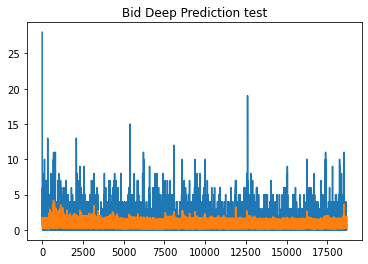

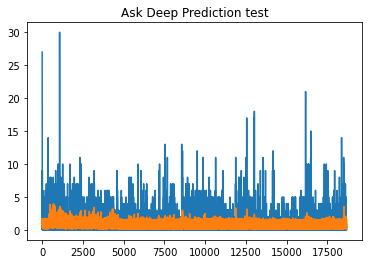

train R2 scores: 0.3093 , 0.3082
train RMSE scores: 1.1558 , 1.1342
train data variation: 1.3908 , 1.3636
test R2 scores: 0.3212 , 0.2669
test RMSE scores: 0.9549 , 1.0775
test data variation: 1.1590 , 1.2584


In [49]:
loadClass = np.load("class.npz")
train_deep  = loadClass["train_deep" ]
test_deep   = loadClass["test_deep"  ]
train_stack = loadClass["train_stack"].reshape((-1,train_deep.shape[0]))
test_stack  = loadClass["test_stack" ].reshape((-1,test_deep.shape[0]))


train_deep_bid = train_stack[0,:]*train_deep[:,1]
train_deep_ask = train_stack[1,:]*train_deep[:,3]

test_deep_bid = test_stack[0,:]*test_deep[:,1]
test_deep_ask = test_stack[1,:]*test_deep[:,3]

plt.figure()
plt.title("Bid Deep Prediction test")
plt.plot(test_data["Bid Arr Pred"].to_numpy())
plt.plot(test_deep_bid)
plt.show()

plt.figure()
plt.title("Ask Deep Prediction test")
plt.plot(test_data["Ask Arr Pred"].to_numpy())
plt.plot(test_deep_ask)
plt.show()


print( 
    "train R2 scores: %0.4f , %0.4f"%(
    r2_score(train_data["Bid Arr Pred"].to_numpy(), train_deep_bid),
    r2_score(train_data["Ask Arr Pred"].to_numpy(), train_deep_ask))
)

print( 
    "train RMSE scores: %0.4f , %0.4f"%(
    np.sqrt(np.mean((train_data["Bid Arr Pred"].to_numpy()- train_deep_bid)**2)),
    np.sqrt(np.mean((train_data["Ask Arr Pred"].to_numpy()- train_deep_ask)**2)))
)

print(
    "train data variation: %0.4f , %0.4f"%(
    np.std(train_data["Bid Arr Pred"].to_numpy()),
    np.std(train_data["Ask Arr Pred"].to_numpy()))
)

print( 
    "test R2 scores: %0.4f , %0.4f"%(
    r2_score(test_data["Bid Arr Pred"].to_numpy(), test_deep_bid),
    r2_score(test_data["Ask Arr Pred"].to_numpy(), test_deep_ask))
)

print( 
    "test RMSE scores: %0.4f , %0.4f"%(
    np.sqrt(np.mean((test_data["Bid Arr Pred"].to_numpy()- test_deep_bid)**2)),
    np.sqrt(np.mean((test_data["Ask Arr Pred"].to_numpy()- test_deep_ask)**2)))
)

print(
    "test data variation: %0.4f , %0.4f"%(
    np.std(test_data["Bid Arr Pred"].to_numpy()),
    np.std(test_data["Ask Arr Pred"].to_numpy()))
)

## Split to Bid data and Ask data

Different than before, when we fitting a regression model, we want to regress the model on the data where the observations are not zero. Thus, we select Bid data and Ask data for which Bid predition and Ask prediction are not zeros respectively. Thus, we would have different data for the two labels. However, for testing data we should not split since a priori, we could not know the labels for test data. 

The way that we want to **combine the regression data and the classification model is by stacking**. Thus, we plan in the final stacking model, we will train the meta model over the whole dataset and use results from the first stack which consists of regression models and the labels from classification and Deep Nets. 

Another caveat is since when we select all possitive label data, we would not have $y=0$ observation for sure. However the model we assumed is Poisson Regression. Therefore, we will subtract one from the y labels for training and when we do actual prediction, we will add one to the models' results.

In [3]:
train_bid = train_data.loc[train_data["Bid Arr Pred"] > 0] 
X_bid = train_bid.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])
y_bid = train_bid["Bid Arr Pred"] - 1
y_bid_class = y_bid.copy()
y_bid_class[y_bid >=10 ] = 10

train_ask = train_data.loc[train_data["Ask Arr Pred"] > 0]
X_ask = train_ask.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])
y_ask = train_ask["Ask Arr Pred"] - 1
y_ask_class = y_ask.copy()
y_ask_class[y_ask >=10 ] = 10

X_test = test_data.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])
y1_test = test_data["Bid Arr Pred"]
y2_test = test_data["Ask Arr Pred"]

## Using Lasso to Select Parameters

From the below plots and the final coefficients plot, it is clear, the features we added are too much for the model and thus we finally use a PCA to reduce dimension and get 50 features in the last. 

In [171]:
glmnet = R["cv.glmnet"]

X_bid_r = robjects.FloatVector(X_bid.to_numpy().flatten())
X_bid_r = R["matrix"](X_bid_r, nrow = X_bid.shape[0])
y_bid_r = robjects.IntVector(y_bid.to_numpy().flatten())

bid = glmnet(X_bid_r, y_bid_r, family="poisson", nfolds = 10) # alter: multinomial


X_ask_r = robjects.FloatVector(X_ask.to_numpy().flatten())
X_ask_r = R["matrix"](X_ask_r, nrow = y_ask.shape[0])
y_ask_r = robjects.IntVector(y_ask.to_numpy().flatten())

ask = glmnet(X_ask_r, y_ask_r, family="poisson", nfolds = 10) # alter: multinomial

ask_lambda_best = np.array(ask[9])[0]
bid_lambda_best = np.array(bid[9])[0]

print(ask_lambda_best, bid_lambda_best)

0.016722011961020355 0.018047539525862945


In [173]:
## for multiclass coefficient
#coef_bid = np.array(R["data.matrix"](R["lapply"](R["coef"](bid, s="lambda.min"), R["as.matrix"] )) )[:,:,0]
#coef_ask = np.array(R["data.matrix"](R["lapply"](R["coef"](ask, s="lambda.min"), R["as.matrix"] )) )[:,:,0]

#coef_bid_mag = np.sqrt(np.sum(coef_bid**2, axis = 0)[1:])
#coef_ask_mag = np.sqrt(np.sum(coef_ask**2, axis = 0)[1:])

#bid_pred_proba = np.array(R["predict"](bid, newx = X_bid_r, s = "lambda.min", type = "response"))[:,:,0]
#ask_pred_proba = np.array(R["predict"](ask, newx = X_ask_r, s = "lambda.min", type = "response"))[:,:,0]

#bid_pred = np.argmax(bid_pred_proba, axis = 1)
#ask_pred = np.argmax(ask_pred_proba, axis = 1)


In [179]:
## for regression coefficient
coef_bid = np.array( R["data.matrix"](R["coef"](bid, s="lambda.min") ))[1:,0]
coef_ask = np.array( R["data.matrix"](R["coef"](ask, s="lambda.min") ))[1:,0]


coef = pd.DataFrame({"Bid": coef_bid.flatten(), "Ask": coef_ask.flatten() },
                    index = train_data.columns.drop(["Bid Arr Pred", "Ask Arr Pred"]) )


bid_pred = np.array(R["predict"](bid, newx = X_bid_r, s = "lambda.min", type = "response"))[:,0]
ask_pred = np.array(R["predict"](ask, newx = X_ask_r, s = "lambda.min", type = "response"))[:,0]

print(
    r2_score(y_bid.to_numpy(), bid_pred) ,
    r2_score(y_ask.to_numpy(), ask_pred)
)

0.0016197712882008997 0.0019586468220801345


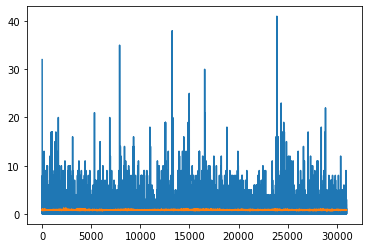

In [176]:
plt.plot(y_bid.to_numpy())
plt.plot(bid_pred)
#for i in range(11):
#    plt.plot(bid_pred_proba[:,i])

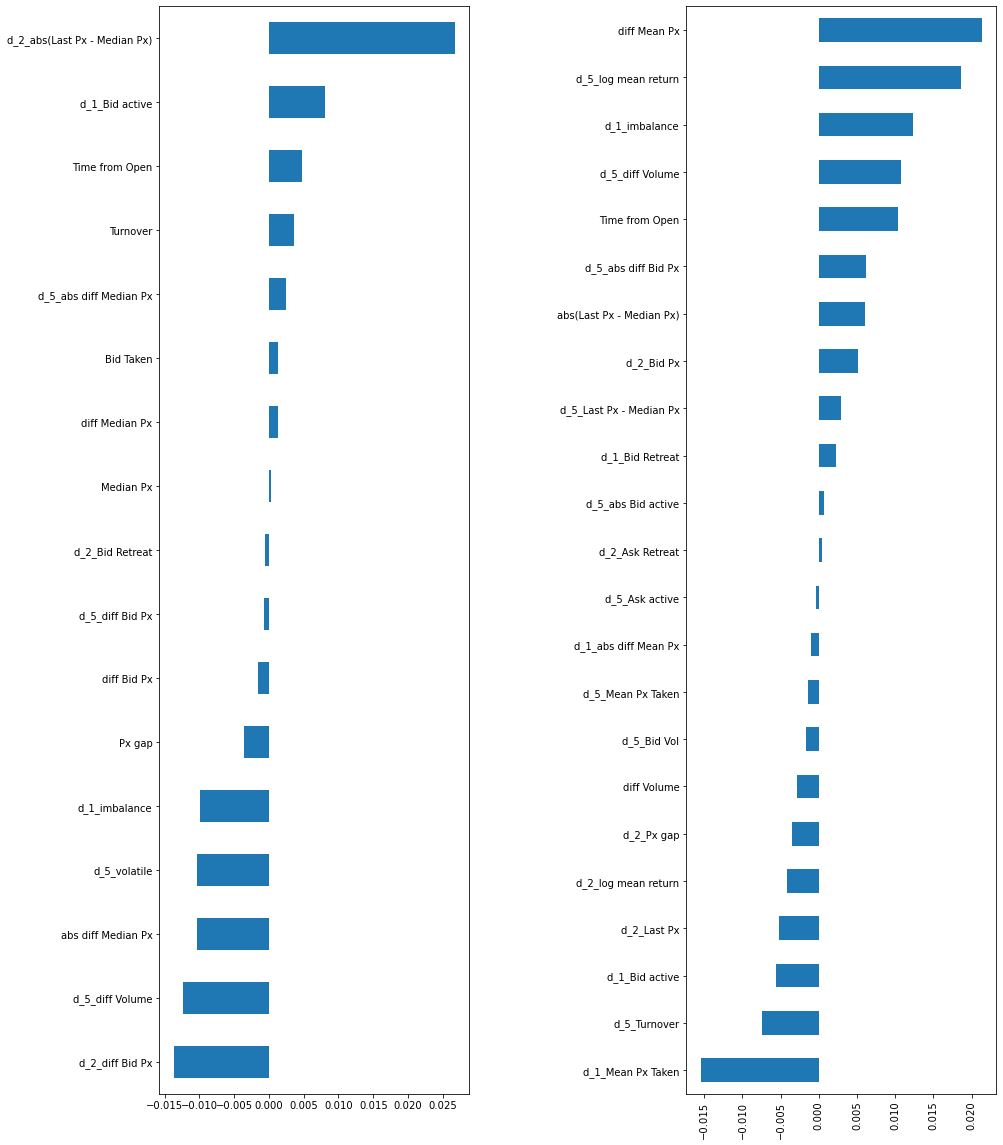

In [180]:
plt.figure(figsize = (25,20))
ax = plt.subplot(121)
coef[coef["Bid"] !=0].sort_values("Bid")["Bid"].plot(kind="barh",figsize=(10,20), ax = ax)
ax = plt.subplot(122)
coef[coef["Ask"] !=0].sort_values("Ask")["Ask"].plot(kind="barh",figsize=(15,20), ax = ax)
plt.xticks(rotation=90)
plt.subplots_adjust(wspace = 0.7)
plt.show()

In [181]:
print("Bid nonzero coef: ", np.sum(coef["Bid"] !=0))
print("Ask nonzero coef: ", np.sum(coef["Ask"] !=0))
print("Bid or Ask use:  ",np.sum(np.logical_or(coef["Ask"] !=0 
                                        ,coef["Bid"] !=0 ) ) )
print("both use:", np.sum(np.logical_and(coef["Ask"] !=0 
                                        ,coef["Bid"] !=0 ) ) )

print("total availabe:", coef.shape[0])

Bid nonzero coef:  17
Ask nonzero coef:  23
Bid or Ask use:   36
both use: 4
total availabe: 143


In [159]:
both_used_features = list(coef.index[np.logical_or(coef["Ask"] !=0,coef["Bid"] !=0 )])

**We see the Regression almost fails since the $R^2$ score is almost zero and the classification is always the zero class. We should try other classification method**

In [182]:
KNN_bid = KNeighborsRegressor()
KNN_bid = KNN_bid.fit(X_bid, y_bid) 
KNN_bid_pred = KNN_bid.predict(X_test) # can only test on test data
print(
    r2_score(y1_test.to_numpy(), KNN_bid_pred)
)

plt.plot(y1_bid.to_numpy())
plt.plot(KNN_bid_pred)

0.3882626492638167


-0.007328945554517796 1.163274840977306


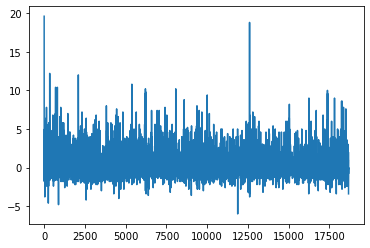

In [195]:
plt.plot(y1_test.to_numpy() - KNN_bid_pred)
#plt.plot(KNN_bid_pred)
print(
    r2_score(y1_test.to_numpy(), KNN_bid_pred),
    np.sqrt(np.mean((y1_test.to_numpy()- KNN_bid_pred)**2))
)

In [196]:
np.std(y1_test.to_numpy())

1.1590353411074013

In [24]:
Poisson_bid = PoissonRegressor(max_iter = 10000, warm_start = True, verbose = 1 )
Poisson_bid = Poisson_bid.fit(X_bid.to_numpy(), y_bid.to_numpy()) 
Poisson_bid_pred = Poisson_bid.predict(X_bid)
print(
    r2_score(y_bid.to_numpy(), Poisson_bid_pred)
)

0.0


In [26]:
Poisson_bid_pred

array([0.82560578, 0.82560578, 0.82560578, ..., 0.82560578, 0.82560578,
       0.82560578])

## PCA transform

We first select the parameters that are all needed for both ask and bid and then we use full PCA to get the explained variance plot and we find there is long platau and thus we should select $80$ degress of components as our input features

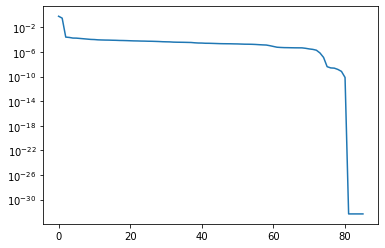

In [15]:
both_used_features = list(coef.index[np.logical_or(coef["Ask"] !=0,coef["Bid"] !=0 )])
X = train_data[both_used_features]
X_test = test_data[both_used_features]

pca = PCA(n_components = 86)
pca.fit(X)
plt.plot(pca.explained_variance_ratio_)
plt.yscale("log")
plt.show()

In [16]:
pca = PCA(n_components = 80)
X_pca = pca.fit(X).transform(X)
X_test_pca = pca.transform(X_test)

## Select Models 

we would first use the following models and try to filter out some good models. 

  - Logistic
  - K-nearest neighbors
  - Gradient Boost
  - XgBoost
  - ExtraTree
  - SVC linear
  - Decision Tree
  - Random Forest
  - AdaBoost
  - NaiveBayes
  - Quadratic Discrimnant Analysis
  

In [17]:
def class_cv(model,X,y, scoring = "f1"):
    
    score = cross_val_score(model, X, y, scoring= scoring, cv=5)
    
    return score

class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid, cv=5, scoring="f1")
        grid_search.fit(X,y)
        print(grid_search.best_params_, grid_search.best_score_)
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

### Selection models for Bid Arrivals

We will first use the PCA output of the transformed inputs to select good models using the score of f1 since f1 socre will be more sensitive to the behaviour of the models. Although, in case we care more about the predictibility of the model (i.e. the probability it estimates for non-zero order arrivals), we should use the AUC score to select the model, the f1 score is more suitable for unbalanced data. Our data is unbalanced and we want more contrast over the behaviour of different models, we will select **f1** socre as our selection rule. 

In [20]:
bid_models_PCA = [
    LogisticRegression(C = 0.1, solver = 'lbfgs'),
    KNeighborsClassifier(n_neighbors = 10, algorithm = "kd_tree"),
    GradientBoostingClassifier(),
    XGBClassifier(n_estimators=20),
    ExtraTreesClassifier(n_estimators = 50),
    LinearSVC(C = 0.1, max_iter = 5000),
    DecisionTreeClassifier(max_depth = 6),
    RandomForestClassifier(max_depth = 4, n_estimators = 20),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), n_estimators=20),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(reg_param=0.01)
]

bid_models_names = [
    "Logit",
    "KNN",
    "GBoost",
    "xgboost",
    "ExTree",
    "linear_SVC",
    "DTree",
    "Forest",
    "AdaBoost",
    "NaiveBayes",
    "QDA"
]

In [21]:
for name, model in zip(bid_models_names, bid_models_PCA):
    score = class_cv(model, X_pca, y1>0)
    auc_score = class_cv(model, X_pca, y1>0, "roc_auc")
    print("{}: {:.6f}, {:.4f}, {:.6f}".format(name,score.mean(),score.std(), auc_score.mean() ))

Logit: 0.711088, 0.0121, 0.826818
KNN: 0.460855, 0.0249, 0.728190
GBoost: 0.664496, 0.0151, 0.811808
xgboost: 0.677168, 0.0135, 0.814608
ExTree: 0.600643, 0.0260, 0.782692
linear_SVC: 0.707182, 0.0124, 0.826238
DTree: 0.574832, 0.0148, 0.746047
Forest: 0.442850, 0.0464, 0.754557
AdaBoost: 0.645697, 0.0138, 0.779460
NaiveBayes: 0.420788, 0.0615, 0.646090
QDA: 0.688317, 0.0139, 0.798981


Since the dimension of the input variables is too big for the KNN given the number of data points in the data set, the behaviour of KNN is very bad and we should reject it. Similar for the NaiveBayes and we would not use it. For the random forest and Decision tree, we did not see great performance. This may be because we used too shallow trees. Then we will consider adjusting some hyperparameters to get a better model. The models we select are 

 - Logistic Regression
 - Gradinet Boost
 - XgBoost
 - Linear SVC
 - Decision Tree
 - AdaBoost
 - Quadratic Discrimnant Analysis
 
we may also try random forest for more trees
 
 - Randome Forest (More Trees)


In [23]:
print("Logit")
param_grid={'C':[100.0, 10.0, 1.0, 0.01,] }
grid(LogisticRegression(max_iter=1000, solver="lbfgs")).grid_get(X_pca,y1>0,param_grid)

print ("XGBClassifier")
param_grid={'n_estimators':[10, 20, 30, 50]}
grid(XGBClassifier()).grid_get(X_pca,y1>0,param_grid)

print("LinearSVC")
param_grid={'C':[1.0, 0.01]}
grid(LinearSVC(max_iter = 5000)).grid_get(X_pca,y1>0,param_grid)

print ("DTree")
param_grid={'max_depth':[5, 10, 15, 20]}
grid(DecisionTreeClassifier()).grid_get(X_pca,y1>0,param_grid)

print("AdaBoost 2")
param_grid={'n_estimators':[10, 40, 50, 70] }
grid(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2) )).grid_get(X_pca,y1>0,param_grid)

print("AdaBoost 4")
param_grid={'n_estimators':[10, 40, 50, 70] }
grid(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 4) )).grid_get(X_pca,y1>0,param_grid)

print("QDA")
param_grid={'reg_param':[1.0, 0.1, 0.001] }
grid(QuadraticDiscriminantAnalysis()).grid_get(X_pca,y1>0,param_grid)

print ("Random Forest")
param_grid={'max_depth':[2, 6, 8, 12], "n_estimators":[50, 100, 150]}
grid(RandomForestClassifier()).grid_get(X_pca,y1>0,param_grid)



Logit
{'C': 0.01} 0.7107154203866328
         params  mean_test_score  std_test_score
0  {'C': 100.0}         0.709866        0.011819
1   {'C': 10.0}         0.709599        0.011825
2    {'C': 1.0}         0.710357        0.011689
3   {'C': 0.01}         0.710715        0.012595
XGBClassifier
{'n_estimators': 50} 0.6936064178013708
                 params  mean_test_score  std_test_score
0  {'n_estimators': 10}         0.652380        0.014316
1  {'n_estimators': 20}         0.677169        0.013518
2  {'n_estimators': 30}         0.684372        0.013395
3  {'n_estimators': 50}         0.693606        0.012437
LinearSVC
{'C': 0.01} 0.7072782798875626
        params  mean_test_score  std_test_score
0   {'C': 1.0}         0.706779        0.012182
1  {'C': 0.01}         0.707278        0.012749
DTree
{'max_depth': 10} 0.5997700208157566
              params  mean_test_score  std_test_score
0   {'max_depth': 5}         0.543757        0.023270
1  {'max_depth': 10}         0.599770      

### Selection models for Ask Arrivals

We will use the same starting models to train on the ask outputs and select some of them to make our final models. However, as we find the KNN could not deal with the high dimension by the curse of dimensionality, we will omit the KNN and use the rest of the models. Then for the Random Forest, we will use more trees than before. 

In [25]:
ask_models_PCA = [
    LogisticRegression(C = 0.1, solver = 'lbfgs'),
    GradientBoostingClassifier(),
    XGBClassifier(n_estimators=20),
    ExtraTreesClassifier(n_estimators = 50),
    LinearSVC(C = 0.1, max_iter = 5000),
    DecisionTreeClassifier(max_depth = 6),
    RandomForestClassifier(max_depth = 4, n_estimators = 50),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), n_estimators=20),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(reg_param=0.01)
]

ask_models_names = [
    "Logit",
    "GBoost",
    "xgboost",
    "ExTree",
    "linear_SVC",
    "DTree",
    "Forest",
    "AdaBoost",
    "NaiveBayes",
    "QDA"
]

In [26]:
for name, model in zip(ask_models_names, ask_models_PCA):
    score = class_cv(model, X_pca, y2>0)
    auc_score = class_cv(model, X_pca, y2>0, "roc_auc")
    print("{}: {:.6f}, {:.4f}, {:.6f}".format(name,score.mean(),score.std(), auc_score.mean() ))

Logit: 0.712363, 0.0144, 0.831260
GBoost: 0.662984, 0.0163, 0.812412
xgboost: 0.672297, 0.0145, 0.812387
ExTree: 0.597642, 0.0227, 0.785281
linear_SVC: 0.708763, 0.0157, 0.830370
DTree: 0.534103, 0.0184, 0.736487
Forest: 0.420623, 0.0541, 0.757194
AdaBoost: 0.643461, 0.0145, 0.780702
NaiveBayes: 0.412500, 0.0554, 0.639483
QDA: 0.688144, 0.0181, 0.799684


Then we will consider adjusting some hyperparameters to get a better model. The models we select are 

 - Logistic Regression
 - Gradinet Boost
 - XgBoost
 - Linear SVC
 - AdaBoost
 - Quadratic Discrimnant Analysis
 
 Then we will fine tune the hyper parameter to make the classification more powerful 


In [27]:
print("Logit")
param_grid={'C':[1000.0, 10.0, 1.0, 0.01, 0.001] }
grid(LogisticRegression(max_iter=1000, solver="lbfgs")).grid_get(X_pca,y2>0,param_grid)

print ("XGBClassifier")
param_grid={'n_estimators':[10, 50, 100, 150]}
grid(XGBClassifier()).grid_get(X_pca,y2>0,param_grid)

print("LinearSVC")
param_grid={'C':[10.0, 1.0, 0.01, 0.001]}
grid(LinearSVC(max_iter = 5000)).grid_get(X_pca,y2>0,param_grid)

print("AdaBoost 2")
param_grid={'n_estimators':[10, 50, 70, 100] }
grid(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2) )).grid_get(X_pca,y2>0,param_grid)

print("AdaBoost 4")
param_grid={'n_estimators':[10, 50, 70, 100] }
grid(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 4) )).grid_get(X_pca,y2>0,param_grid)

print("QDA")
param_grid={'reg_param':[1.0, 0.1 , 0.01, 0.001] }
grid(QuadraticDiscriminantAnalysis()).grid_get(X_pca,y2>0,param_grid)



Logit
{'C': 1.0} 0.7125759708434605
          params  mean_test_score  std_test_score
0  {'C': 1000.0}         0.711809        0.014039
1    {'C': 10.0}         0.711914        0.014401
2     {'C': 1.0}         0.712576        0.014483
3    {'C': 0.01}         0.711646        0.014552
4   {'C': 0.001}         0.709173        0.016084
XGBClassifier
{'n_estimators': 70} 0.6985042926056843
                 params  mean_test_score  std_test_score
0  {'n_estimators': 10}         0.638714        0.017333
1  {'n_estimators': 30}         0.684568        0.013472
2  {'n_estimators': 50}         0.693486        0.014400
3  {'n_estimators': 70}         0.698504        0.012833
LinearSVC
{'C': 1.0} 0.7087435040405398
         params  mean_test_score  std_test_score
0   {'C': 10.0}         0.707038        0.017295
1    {'C': 1.0}         0.708744        0.015372
2   {'C': 0.01}         0.708201        0.015800
3  {'C': 0.001}         0.707238        0.015800
AdaBoost 2
{'n_estimators': 100} 0.69412

## Stacking the Models for the classification

We first append the deep net results to the data since we would like to train the meta classifier in the second stack of our stack with the inputs from the deep Nets. 


In [29]:
from DeepNets.train import load_and_evaluate

bid_path = "./DeepNets/bid_CNN_2.pth"
ask_path = "./DeepNets/ask_CNN_2.pth"

train_data_deep = load_and_evaluate([bid_path, ask_path], train_data_original)
test_data_deep  = load_and_evaluate([bid_path, ask_path], test_data_original )

train_data_deep = train_data_deep.to_numpy()
test_data_deep  = test_data_deep.to_numpy()


          bid_model  ask_model
loss       0.988220   0.966312
AUC        0.536012   0.545173
f1_score   0.448910   0.000000
accuracy   0.534717   0.614826
          bid_model  ask_model
loss       0.985975   0.967239
AUC        0.445893   0.562891
f1_score   0.000000   0.000000
accuracy   0.623536   0.626218


AttributeError: 'NoneType' object has no attribute 'to_numpy'

In [30]:
from DeepNets.train import load_and_evaluate

bid_path = "./DeepNets/bid_CNN_2.pth"
ask_path = "./DeepNets/ask_CNN_2.pth"

train_data_deep = load_and_evaluate([bid_path, ask_path], train_data_original)
test_data_deep  = load_and_evaluate([bid_path, ask_path], test_data_original )

train_data_deep = train_data_deep.to_numpy()
test_data_deep  = test_data_deep.to_numpy()


          bid_model  ask_model
loss       1.119098   0.959389
AUC        0.446333   0.557607
f1_score   0.561258   0.170395
accuracy   0.390167   0.622002
          bid_model  ask_model
loss       0.996832   0.976029
AUC        0.461893   0.542309
f1_score   0.073504   0.000000
accuracy   0.610892   0.626273


AttributeError: 'NoneType' object has no attribute 'to_numpy'

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)

    def fit(self,X,y, append = None):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))

        for i,model in enumerate(self.mod):
            print ("training for " + str(i) + " out of " + str(len(self.mod)))
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                if (type(model).__name__ == 'LinearSVC'):
                    oof_train[val_index,i] = renew_model.predict(X[val_index])
                else:
                    oof_train[val_index,i] = renew_model.predict_proba(X[val_index])[:,1]
        if (append):
            oof_train = np.hstack([oof_train, append])
        self.meta_model.fit(oof_train,y)
        return self

    def predict(self,X, append= None):
        whole_test = np.column_stack([
                np.column_stack(
                    [model.predict_proba(X)[:,1] for model in single_model]
                ).mean(axis=1) 
            if (type(single_model[0]).__name__ != 'LinearSVC')
            else 
                np.column_stack(
                    [model.predict(X) for model in single_model]
                ).mean(axis=1) 
            for single_model in self.saved_model
        ])
        if (append):
            whole_test = np.hstack([whole_test,append])
        return self.meta_model.predict_proba(whole_test)[:,1]

    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [54]:
bid_models_PCA = [
    LogisticRegression(C = 0.1, solver = 'lbfgs'),
    GradientBoostingClassifier(),
    XGBClassifier(n_estimators=70),
    LinearSVC(C = 0.01, max_iter = 5000),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), n_estimators=70),
    QuadraticDiscriminantAnalysis(reg_param=0.001)
]
Base_model = LogisticRegression(C = 0.1, solver = 'lbfgs')
bidstack = stacking(bid_models_PCA, Base_model )
bidstack.fit(X_pca, y1 > 0)


training for 0 out of 8
training for 1 out of 8
training for 2 out of 8


KeyboardInterrupt: 

In [ ]:
ask_models_PCA = [
    LogisticRegression(C = 1.0, solver = 'lbfgs'),
    GradientBoostingClassifier(),
    XGBClassifier(n_estimators=50),
    LinearSVC(C = 0.1, max_iter = 5000),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), n_estimators=100),
    QuadraticDiscriminantAnalysis(reg_param=0.001)
]
Base_model = LogisticRegression(C = 0.1, solver = 'lbfgs')
bidstack = stacking(ask_models_PCA, Base_model )
bidstack.fit(X_pca, y1 > 0)

In [40]:
bid_pred = bid_stack.predict(X_pca)

In [23]:
def plotROC(target, pred):
    plt.show()
    fpr1, tpr1, t1 = roc_curve(target, pred)
    plt.plot(fpr1, tpr1)
    plt.plot(fpr1,fpr1)
    
    plt.show()
    AUC = auc(fpr1, tpr1)
    print ("AUC:", AUC)
    return AUC

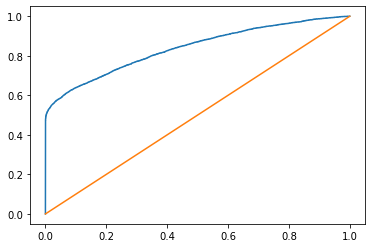

AUC: 0.8382676301669364


0.8382676301669364

In [41]:
plotROC(y1 >0, bid_pred)

In [53]:
print(
    "Accuracy:", np.mean((y1_test>0) == (bid_pred >0.5))
    "f1_score:", f1_score(y1_test > 0.0, bid_pred > 0.5)
)

0.8094804499196572

## Ask Model:

In [ ]:
ask_models_PCA = [
    LogisticRegression(C = 0.1, solver = 'lbfgs'),
    KNeighborsClassifier(n_neighbors = 10, algorithm = "kd_tree"),
    GradientBoostingClassifier(),
    XGBClassifier(n_estimators=20),
    ExtraTreesClassifier(n_estimators = 50),
    LinearSVC(C = 0.025, max_iter = 5000),
    DecisionTreeClassifier(max_depth = 6),
    RandomForestClassifier(max_depth = 4, n_estimators = 10),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2) ),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(reg_param=0.01)
]

ask_models_names = [
    "Logit",
    "KNN",
    "GBoost",
    "xgboost",
    "ExTree",
    "linear_SVC",
    "DTree",
    "Forest",
    "AdaBoost",
    "NaiveBayes",
    "QDA"
]

In [ ]:
for name, model in zip(ask_models_names, ask_models_PCA):
    score = class_cv(model, X_pca, y1>0)
    auc_score = class_cv(model, X_pca, y1>0, "roc_auc")
    print("{}: {:.6f}, {:.4f}, {:.6f}".format(name,score.mean(),score.std(), auc_score.mean() ))

In [ ]:
print("Logit")
param_grid={'C':[10.0,1.0,0.1,0.01], "l1_ratio":[0.5, 0.0]}
grid(LogisticRegression(penalty = "elasticnet", solver="saga", max_iter=1000)).grid_get(X_pca,y1>0,param_grid)


print("KNN")
param_grid={'n_neighbors':[2, 4, 6, 10, 15]}
grid(KNeighborsClassifier(algorithm = "kd_tree")).grid_get(X_pca,y1>0,param_grid)


print ("XGBClassifier")
param_grid={'n_estimators':[10, 20, 50, 100]}
grid(XGBClassifier()).grid_get(X_pca,y1>0,param_grid)


print ("EXTree")
param_grid={'n_estimators':[10, 20, 50, 100]}
grid(ExtraTreesClassifier()).grid_get(X_pca,y1>0,param_grid)


print("LinearSVC")
param_grid={'C':[10.0,1.0,0.1,0.01]}
grid(LinearSVC()).grid_get(X_pca,y1>0,param_grid)


print("Forest")
param_grid={'max_depth':[1,2,4,8], "n_estimators": [5, 10, 20] }
grid(RandomForestClassifier()).grid_get(X_pca,y1>0,param_grid)


print("AdaBoost")
param_grid={'max_depth':[1,2,4,8] }
AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2) )


In [5]:
train_data

,Last Px,Turnover,Volume,Bid Px,Bid Vol,Ask Px,Ask Vol,Bid Arrival,Ask Arrival,Bid Retreat,...,diff Bid Px,diff Ask Px,log mean return,imbalance,Px gap,Bid active,Ask active,volatile,Last Px - Median Px,Time from Open
Time,,,,,,,,,,,,,,,,,,,,,
2017-05-24 07:02:58.200,17010,0,0,NaN,0,NaN,0,0.0,0.0,0.0,...,NaN,NaN,NaN,0,NaN,0.000000,0.000000,NaN,NaN,25378
2017-05-24 09:29:00.200,16996,781816,46,16996.0,2,16997.0,3,33.0,35.0,0.0,...,-5.0,-2.0,-0.000206,-1,0.000059,10.121908,11.878092,NaN,-0.5,34140
2017-05-24 09:30:00.200,16994,917772,54,16991.0,1,16995.0,9,9.0,16.0,1.0,...,-3.0,-1.0,-0.000118,-8,0.000235,0.000000,15.000000,NaN,1.0,34200
2017-05-24 09:30:00.700,16995,1121690,66,16988.0,1,16994.0,1,8.0,8.0,3.0,...,-4.0,-6.0,-0.000294,0,0.000353,-0.500000,1.500000,NaN,4.0,34200
2017-05-24 09:30:01.200,16985,1240602,73,16984.0,1,16988.0,10,13.0,21.0,3.0,...,-2.0,-4.0,-0.000177,-9,0.000235,3.000000,20.000000,NaN,-1.0,34201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-31 14:59:59.300,17410,248356774,14231,17409.0,2,17411.0,11,0.0,1.0,5.0,...,0.0,-1.0,-0.000029,-9,0.000115,-6.000000,1.000000,0.000033,0.0,53999
2017-05-31 15:00:00.300,17410,248356774,14231,17409.0,2,17410.0,1,0.0,1.0,0.0,...,0.0,0.0,0.000000,1,0.000057,0.000000,0.000000,0.000033,0.5,54000
2017-05-31 15:21:34.800,17410,248356774,14231,17409.0,2,17410.0,1,0.0,0.0,0.0,...,0.0,0.0,0.000000,1,0.000057,0.000000,0.000000,0.000033,0.5,55294


In [6]:
set(data.index.floor("D"))

{Timestamp('2017-05-24 00:00:00'),
 Timestamp('2017-05-25 00:00:00'),
 Timestamp('2017-05-26 00:00:00'),
 Timestamp('2017-05-31 00:00:00'),
 Timestamp('2017-06-01 00:00:00')}

In [34]:
from DeepNets.train import load_and_evaluate

from .DeepNets.Architechtures import OrderArrival_Dataset as OrderData
OrderData(train_data_original)

ImportError: attempted relative import with no known parent package